 ## Milestone 3 - Exploratory Data Analysis

#### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from db_utils import RDSDatabaseConnector
from classes import DataTransform
custloan_df = pd.read_csv(r'C:\Users\tde_v\CourseAI\customer_loans\loan_payments.csv')


#### 1. Convert columns to correct format
###### - These columns to be transformed as follows: 
###### employment_length - object to int64. ie. strings like '< 1 year', '2 years', '10+ years' to numeric values.


In [2]:
transform_employment_length = DataTransform(custloan_df)
transform_employment_length.convert_employment_to_numeric("employment_length")
print(transform_employment_length.df["employment_length"].head(10))

0     5.0
1     9.0
2     8.0
3     1.0
4    10.0
5     0.0
6     NaN
7     0.0
8     0.0
9    10.0
Name: employment_length, dtype: float64


#### Information from DataFrame

In [3]:
from classes import DataFrameInfo
df_info = DataFrameInfo(custloan_df)


#### Remove/impute missing values

In [4]:
from classes import DataFrameTransform
from classes import Plotter
df_transform = DataFrameTransform(custloan_df)
plotter = Plotter(custloan_df)

##### Determine amount of NULLs in each column

In [5]:
null_counts_before = custloan_df.isnull().sum()
df_info.null_value_summary()

NULL Value Summary:
                             Null Count  Null Percentage
funded_amount                      3007         5.544799
term                               4772         8.799395
int_rate                           5169         9.531449
employment_length                  2118         3.905515
mths_since_last_delinq            31002        57.166565
mths_since_last_record            48050        88.602460
last_payment_date                    73         0.134609
next_payment_date                 32608        60.127971
last_credit_pull_date                 7         0.012908
collections_12_mths_ex_med           51         0.094042
mths_since_last_major_derog       46732        86.172116




-- Decided to drop all columns with NULL percentage over 50.

In [6]:
df_transform.drop_high_null_columns(threshold=50)

Dropped columns with >50% NULLs: ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']



 -- Impute remaining NULLs

In [7]:
df_transform.impute_nulls()

Imputed column 'funded_amount' with mean.
Imputed column 'int_rate' with mean.
Imputed column 'employment_length' with mean.
Imputed column 'collections_12_mths_ex_med' with median.
Imputed column 'term' with mode: '36 months'.
Imputed column 'last_payment_date' with mode: 'Jan-2022'.
Imputed column 'last_credit_pull_date' with mode: 'Jan-2022'.




##### -- Re-run NULL checking

In [8]:
null_counts_after = custloan_df.isnull().sum()
df_info.null_value_summary()

NULL Value Summary:
Empty DataFrame
Columns: [Null Count, Null Percentage]
Index: []




##### - Visualise NULL removal

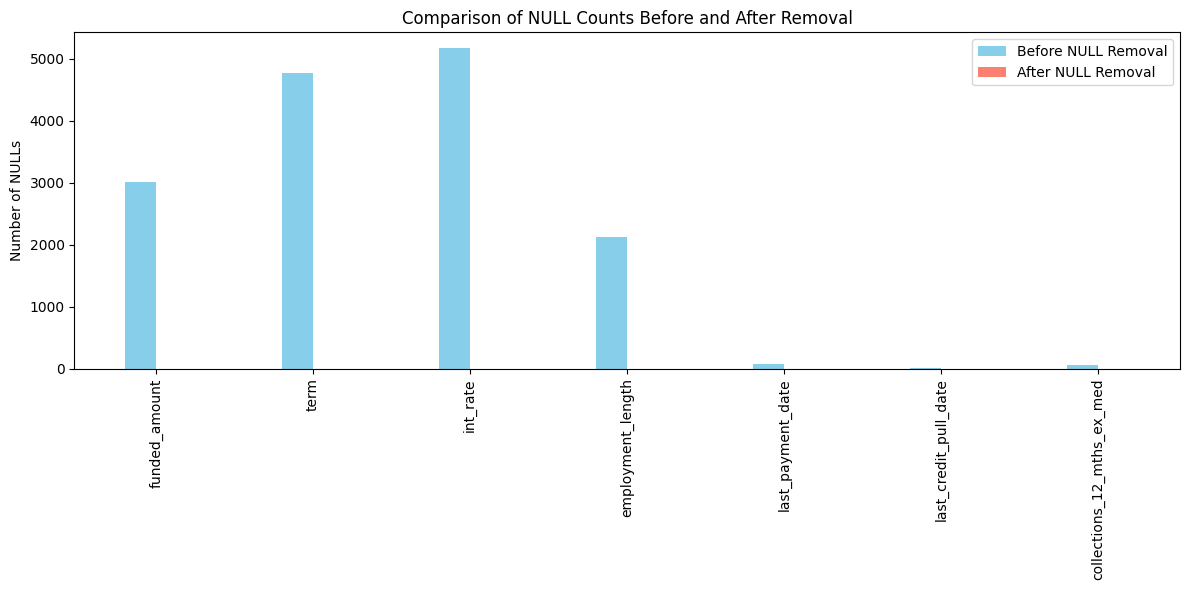

In [9]:
plotter.plot_nulls(null_counts_before, null_counts_after)

### Identify Skewed Columns

##### -- First, identify columns with large percentage of zero or blank values

In [10]:
df_info.zero_or_blank_percentage()

c:\Users\tde_v\CourseAI\customer_loans\classes.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  blank_percent = (self.df.applymap(lambda x: isinstance(x, str) and x.strip() == '')).sum() / total_rows * 100


Percentage of Zero or Blank Values in Each Column:
 - funded_amount_inv: 0.20%
 - employment_length: 9.28%
 - dti: 0.20%
 - delinq_2yrs: 84.14%
 - inq_last_6mths: 49.99%
 - out_prncp: 62.62%
 - out_prncp_inv: 62.62%
 - total_payment: 0.04%
 - total_payment_inv: 0.27%
 - total_rec_prncp: 0.14%
 - total_rec_int: 0.13%
 - total_rec_late_fee: 96.75%
 - recoveries: 93.24%
 - collection_recovery_fee: 93.65%
 - last_payment_amount: 0.14%
 - collections_12_mths_ex_med: 99.61%


In [11]:
# Identify skewed columns, excluding columns with >40% zero/blank data
df_info.identify_skewed_columns(threshold=0, zero_threshold=0.4)

Skewed Columns (>|0| skewness, excluding >40.0% zeros):
 - id: 2.370
 - member_id: 2.205
 - loan_amount: 0.805
 - funded_amount: 0.846
 - funded_amount_inv: 0.814
 - int_rate: 0.433
 - instalment: 0.997
 - employment_length: -0.118
 - annual_inc: 8.712
 - dti: 0.189
 - open_accounts: 1.059
 - total_accounts: 0.779
 - total_payment: 1.268
 - total_payment_inv: 1.256
 - total_rec_prncp: 1.261
 - total_rec_int: 2.204
 - last_payment_amount: 2.499


##### - Set threshold as 1, disregard non-mathematical columns ('id' & 'member_id'), and visualise the skew.

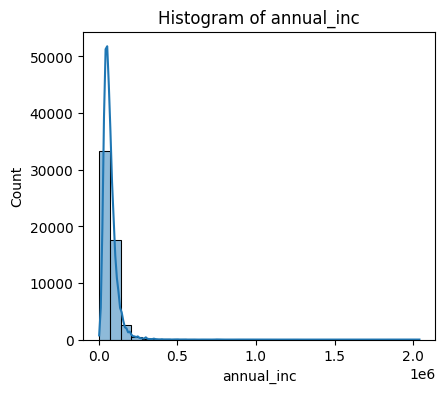

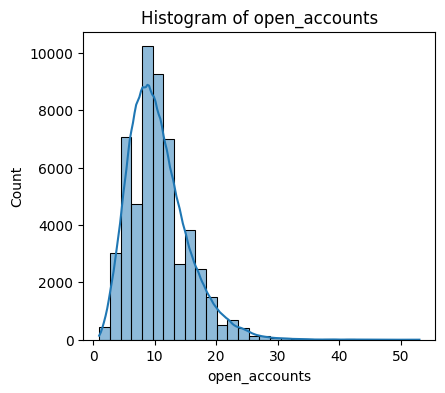

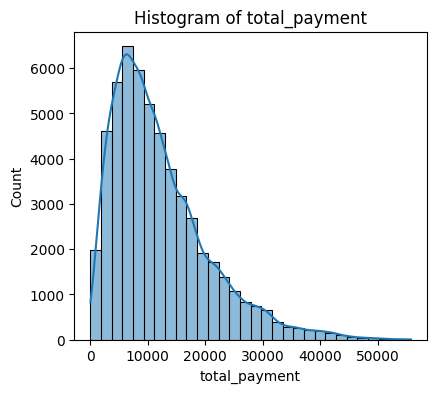

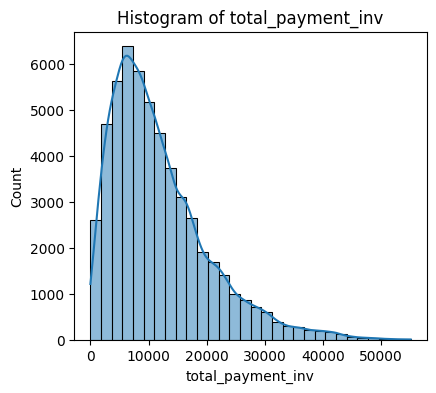

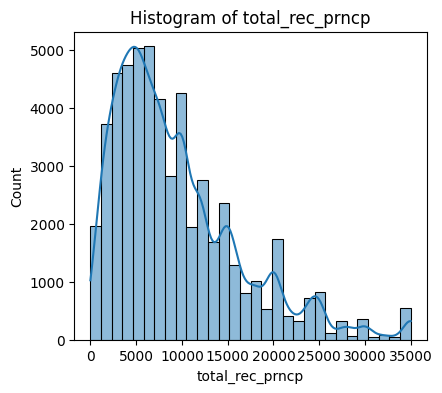

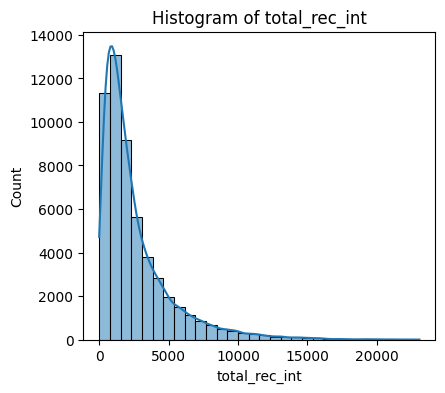

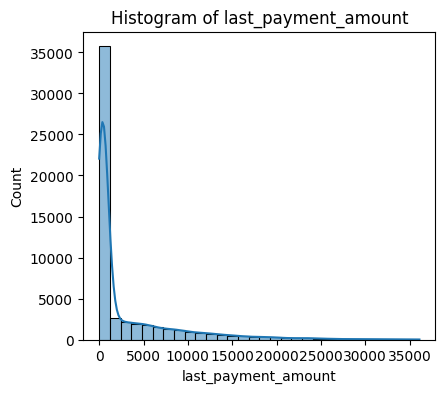

In [12]:
skewed_columns = plotter.plot_skew(threshold=1, exclude_cols=['id', 'member_id'])

##### --Transform columns to reduce skew, and visualise the results.

In [13]:
df_transform.transform_skewed_columns(threshold=1, exclude_cols=['id', 'member_id'])

Applied boxcox transformation to annual_inc. Skewness after: -0.011948183974555437
Applied boxcox transformation to open_accounts. Skewness after: 0.001819492598839149
Applied boxcox transformation to total_payment. Skewness after: -0.004029802680351841
Applied boxcox transformation to total_payment_inv. Skewness after: 0.004963861747204874
Applied boxcox transformation to total_rec_prncp. Skewness after: -0.004196163930908247
Applied boxcox transformation to total_rec_int. Skewness after: 0.020837071070294075
Applied boxcox transformation to last_payment_amount. Skewness after: -0.0017660827663652295




### Visualise Outliers

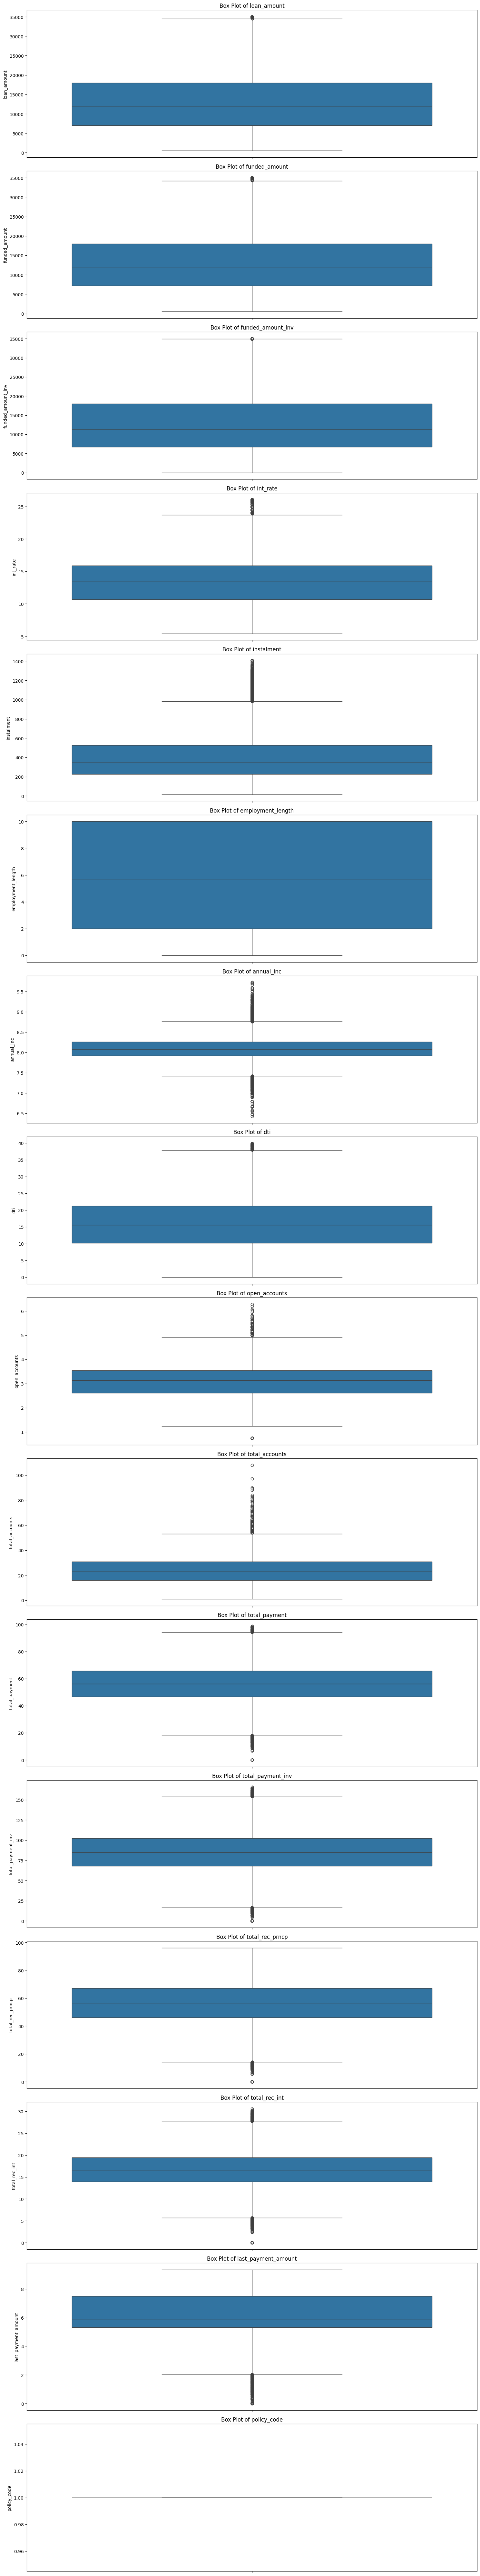

In [ ]:
# Excluding columns with >40% zero values
numeric_cols = custloan_df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'member_id']]
plotter.plot_outliers(numeric_cols, zero_threshold=40)

##### - Remove outliers with IQR threashold of >1.5

In [15]:
df_transform.handle_outliers(method="remove", threshold=1.5)

Removed outliers from loan_amount.
Removed outliers from funded_amount.
Removed outliers from funded_amount_inv.
Removed outliers from int_rate.
Removed outliers from instalment.
Removed outliers from employment_length.
Removed outliers from annual_inc.
Removed outliers from dti.
Removed outliers from open_accounts.
Removed outliers from total_accounts.
Removed outliers from total_payment.
Removed outliers from total_payment_inv.
Removed outliers from total_rec_prncp.
Removed outliers from total_rec_int.
Removed outliers from last_payment_amount.
Removed outliers from policy_code.


##### - Revisualise outliers

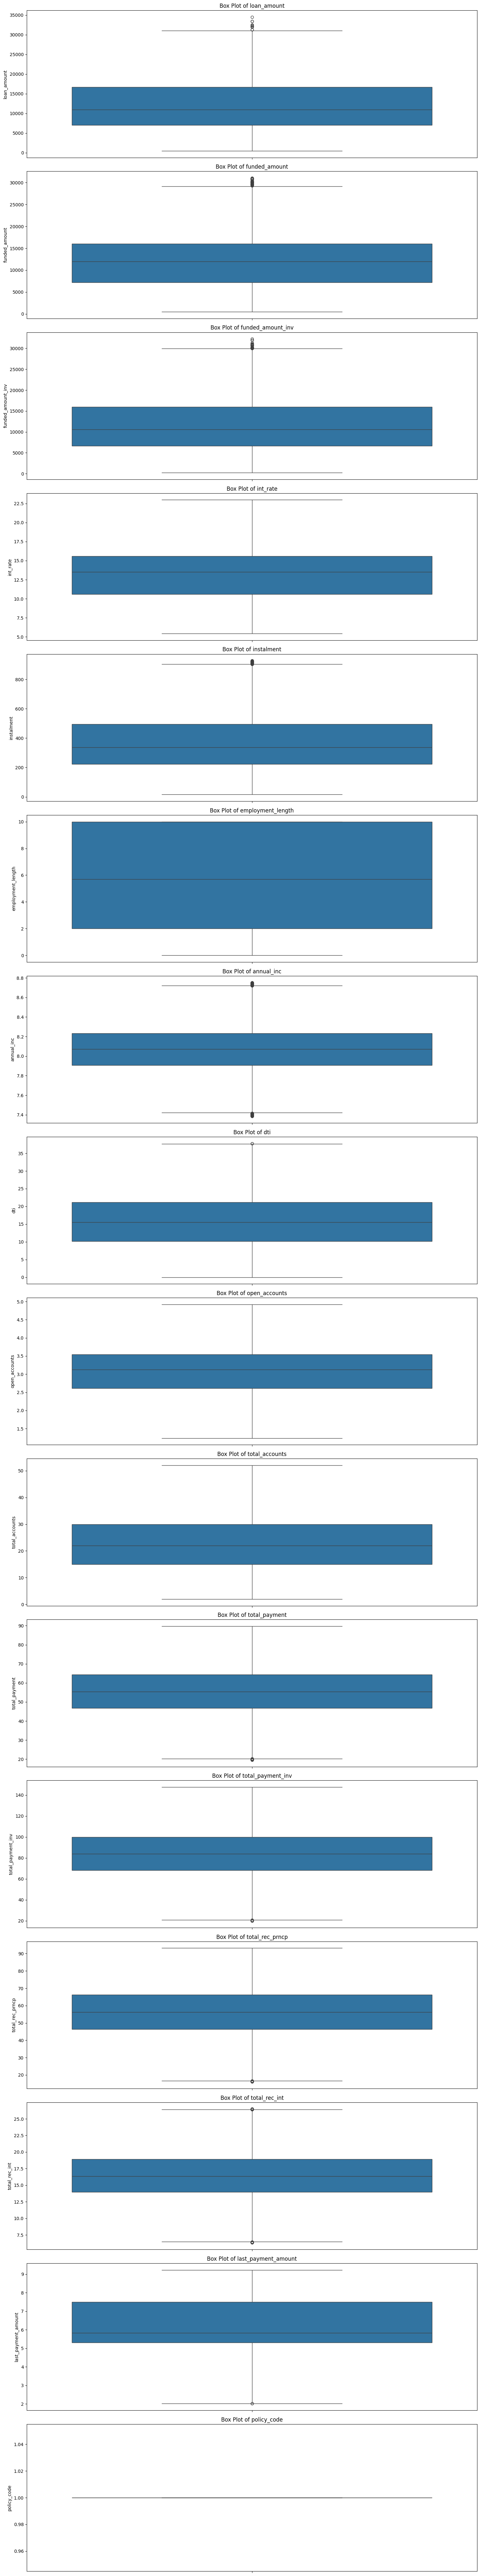

In [16]:
numeric_cols = custloan_df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'member_id']]
df_transform.replot_outliers(numeric_cols, zero_threshold=40)

### Overly Correlated Columns
##### - Visualise Correlation

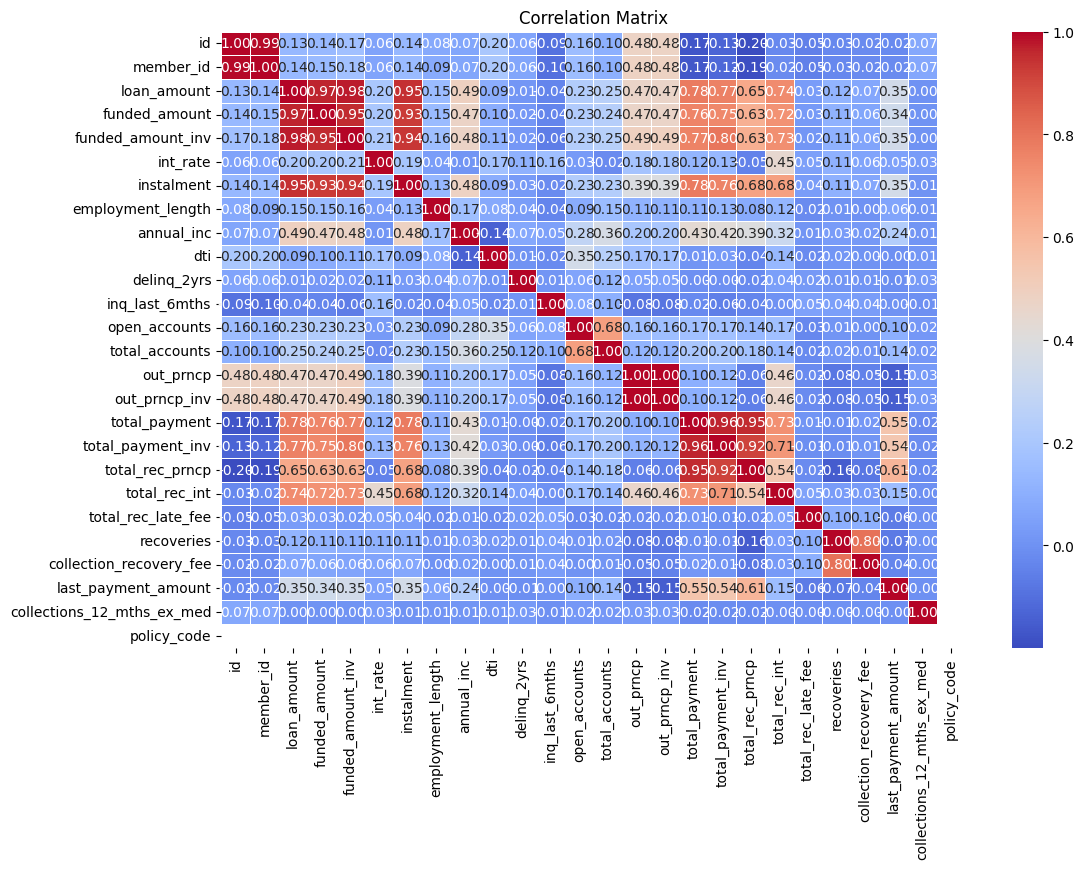

In [17]:
plotter.plot_correlation_matrix()

##### - Remove correlated data above threshold of 0.85

In [18]:
numeric_cols = custloan_df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'member_id']]
df_transform.identify_highly_correlated_columns()

Highly correlated columns (>|0.85| correlation): ['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'out_prncp_inv', 'total_payment_inv', 'total_rec_prncp']



['member_id',
 'funded_amount',
 'funded_amount_inv',
 'instalment',
 'out_prncp_inv',
 'total_payment_inv',
 'total_rec_prncp']

In [19]:
df_transform.remove_highly_correlated_columns()

Highly correlated columns (>|0.85| correlation): ['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'out_prncp_inv', 'total_payment_inv', 'total_rec_prncp']

Removed columns: ['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'out_prncp_inv', 'total_payment_inv', 'total_rec_prncp']


### Milestone 4 - Analysis and Visualisation

##### - Current state of the loans

3046388.4843010856
927668822.52


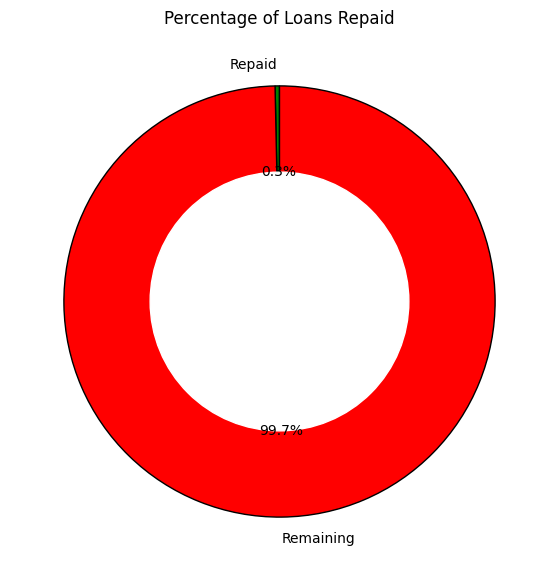

In [20]:

# Extract numbers from "term" column
custloan_df["term"] = custloan_df["term"].astype(str).str.extract("(\\d+)").astype(float)

# Calculate the total amount due for each loan
custloan_df["total_due"] = custloan_df["term"] * custloan_df["instalment"]

# Calculate percentage of loans repaid
total_repaid = custloan_df["total_payment"].sum()
total_due = custloan_df["total_due"].sum()
repaid_percentage = (total_repaid / total_due) * 100
remaining_percentage = 100 - repaid_percentage

print(total_repaid)
print(total_due)
import matplotlib.pyplot as plt

# Plot as a donut chart
plt.figure(figsize=(7, 7))
plt.pie(
    [repaid_percentage, remaining_percentage], 
    labels=["Repaid", "Remaining"], 
    autopct="%1.1f%%", 
    colors=["green", "red"], 
    startangle=90, 
    wedgeprops={"edgecolor": "black"}
)
plt.gca().add_artist(plt.Circle((0, 0), 0.6, color="white")) 
plt.title("Percentage of Loans Repaid")
plt.show()

##### - How much will be paid back in 6 months time?

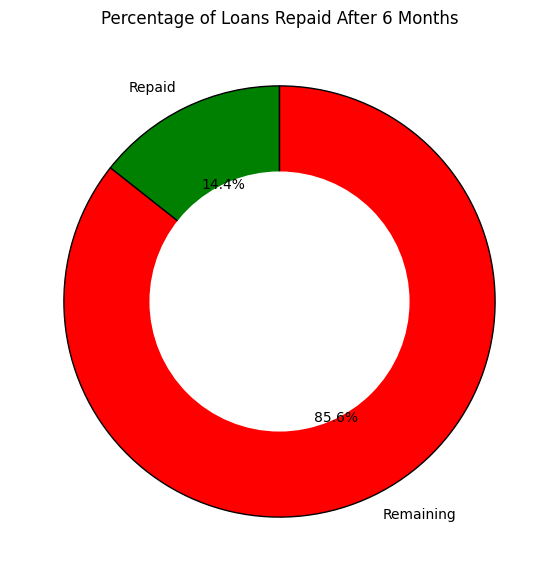

In [21]:
# Calculate remaining months for each loan
custloan_df["months_left"] = custloan_df["term"] - (custloan_df["total_payment"] / custloan_df["instalment"])

# Calculate additional payments expected in 6 months
custloan_df["6mnth_payments"] = custloan_df["months_left"].clip(upper=6) * custloan_df["instalment"]

# Calculate the total expected repaid after 6 months
total_repaid_6mnths = custloan_df["total_payment"].sum() + custloan_df["6mnth_payments"].sum()

# Calculate the recovery percentage in 6 months
repaid_percentage_6mnths = (total_repaid_6mnths / total_due) * 100
remaining_percentage_6mnths = 100 - repaid_percentage_6mnths

# Plot as a donut chart
plt.figure(figsize=(7, 7))
plt.pie(
    [repaid_percentage_6mnths, remaining_percentage_6mnths], 
    labels=["Repaid", "Remaining"], 
    autopct="%1.1f%%", 
    colors=["green", "red"], 
    startangle=90, 
    wedgeprops={"edgecolor": "black"}
)
plt.gca().add_artist(plt.Circle((0, 0), 0.6, color="white")) 
plt.title("Percentage of Loans Repaid After 6 Months")
plt.show()

##### - Calculating loss

In [22]:
# Filter and calculate percentage of charged off loans within total loans
total_loans = len(custloan_df)
charged_off_loans = custloan_df[custloan_df["loan_status"] == "Charged Off"]
charged_off_percentage = (len(charged_off_loans) / total_loans) * 100

# Calculate total amount paid towards charged off loans
total_paid_charged_off = charged_off_loans["total_payment"].sum()

# Print results
print(f"Percentage of Charged Off Loans: {charged_off_percentage:.2f}%")
print(f"Total Paid Before Charge Off: ${total_paid_charged_off:,.2f}")

Percentage of Charged Off Loans: 10.27%
Total Paid Before Charge Off: $250,425.02


##### - Calculating projected loss

C:\Users\tde_v\AppData\Local\Temp\ipykernel_24572\381852133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans["term"] = charged_off_loans["term"].astype(str).str.extract("(\\d+)").astype(float)
C:\Users\tde_v\AppData\Local\Temp\ipykernel_24572\381852133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans["charged_off_total_payment"] = charged_off_loans["instalment"] * charged_off_loans["term"]
C:\Users\tde_v\AppData\Local\Temp\ipykernel_24572\381852133.py:8: SettingWith

Total Loss from Charged Off Loans: $101,818,934.86


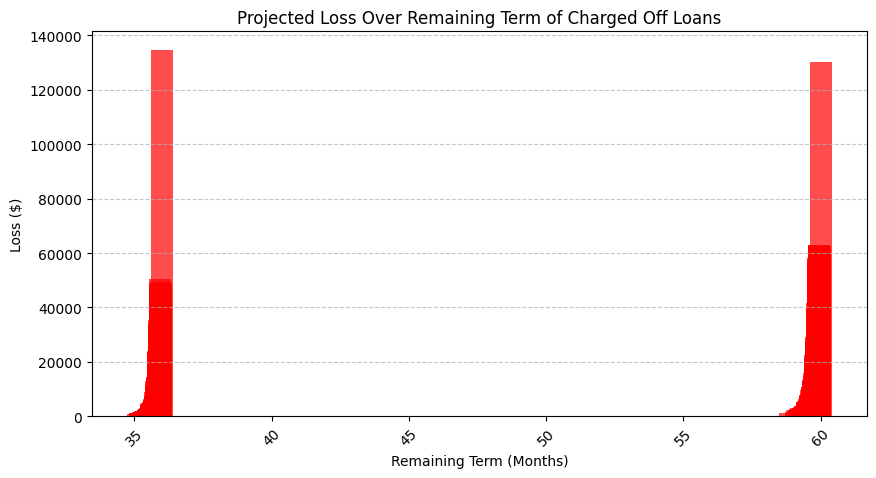

In [23]:
# Extract the number from filtered "term" column 
charged_off_loans["term"] = charged_off_loans["term"].astype(str).str.extract("(\\d+)").astype(float)

# Calculate expected total payment for charged off loans
charged_off_loans["charged_off_total_payment"] = charged_off_loans["instalment"] * charged_off_loans["term"]

# Calculate amount lost on charged off loans
charged_off_loans["amount_lost"] = charged_off_loans["charged_off_total_payment"] - charged_off_loans["total_payment"]
total_loss_charge_off = charged_off_loans["amount_lost"].sum()

# Print results
print(f"Total Loss from Charged Off Loans: ${total_loss_charge_off:,.2f}")

# Visualize projected loss over the remaining term
charged_off_loans["remaining_term"] = charged_off_loans["term"] - (charged_off_loans["total_payment"] / charged_off_loans["instalment"])

# Group by remaining months to sum losses
loss_by_remaining_term = charged_off_loans.groupby("remaining_term")["amount_lost"].sum()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(loss_by_remaining_term.index, loss_by_remaining_term.values, color='red', alpha=0.7)
plt.xlabel("Remaining Term (Months)")
plt.ylabel("Loss ($)")
plt.title("Projected Loss Over Remaining Term of Charged Off Loans")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

##### - Possible loss

In [24]:
# Filter and calculate percentage of loans where customer is behind with payments
behind_with_loans = custloan_df[custloan_df["payment_plan"] == "y"]
behind_with_loan_percentage = (len(behind_with_loans) / total_loans) * 100

# Print percentage
print(f"Percentage of at-risk loans: {behind_with_loan_percentage:.2f}%")

# Calculate total amount paid by customers that are behind with payments
total_paid_behind_with_loan = behind_with_loans["total_payment"].sum()

# Extract the number from filtered "term" column 
behind_with_loans["term"] = behind_with_loans["term"].astype(str).str.extract("(\\d+)").astype(float)

# Calculate expected total payment for customers behind with loans
behind_with_loans["behind_with_loan_total_payment"] = behind_with_loans["instalment"] * behind_with_loans["term"]

# Calculate amount lost on customers behind with loans, if changed to "charged off"
behind_with_loans["amount_lost"] = behind_with_loans["behind_with_loan_total_payment"] - behind_with_loans["total_payment"]
total_loss_behind_with_loans = behind_with_loans["amount_lost"].sum()

# What is the projected loss of these loans if the customer were to finish the full loan term? [surely this is zero?]

# Calculate percentage of total expected revenue of at-risk customers and those already charged off
total_expected_at_risk_or_charged_off = behind_with_loans["behind_with_loan_total_payment"].sum() + charged_off_loans["charged_off_total_payment"].sum()
percentage_of_at_risk_plus_charged_off = (total_expected_at_risk_or_charged_off / total_due) * 100
print(f"Percentage of total expected revenue of at-risk and charged off customers: {percentage_of_at_risk_plus_charged_off:,.2f}")


Percentage of at-risk loans: 0.00%
Percentage of total expected revenue of at-risk and charged off customers: 11.00


C:\Users\tde_v\AppData\Local\Temp\ipykernel_24572\941836724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behind_with_loans["term"] = behind_with_loans["term"].astype(str).str.extract("(\\d+)").astype(float)
C:\Users\tde_v\AppData\Local\Temp\ipykernel_24572\941836724.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behind_with_loans["behind_with_loan_total_payment"] = behind_with_loans["instalment"] * behind_with_loans["term"]
C:\Users\tde_v\AppData\Local\Temp\ipykernel_24572\941836724.py:18: Set

##### - Indicators of loss

Filtered 6257 loans that are either charged off or at risk.


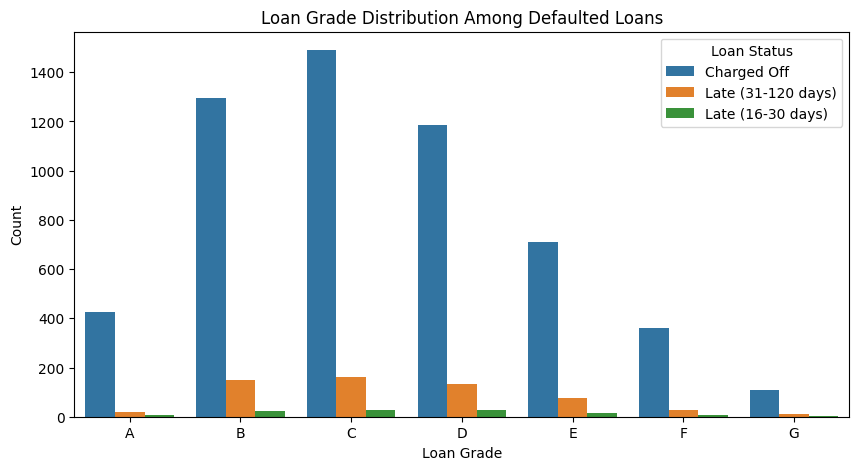

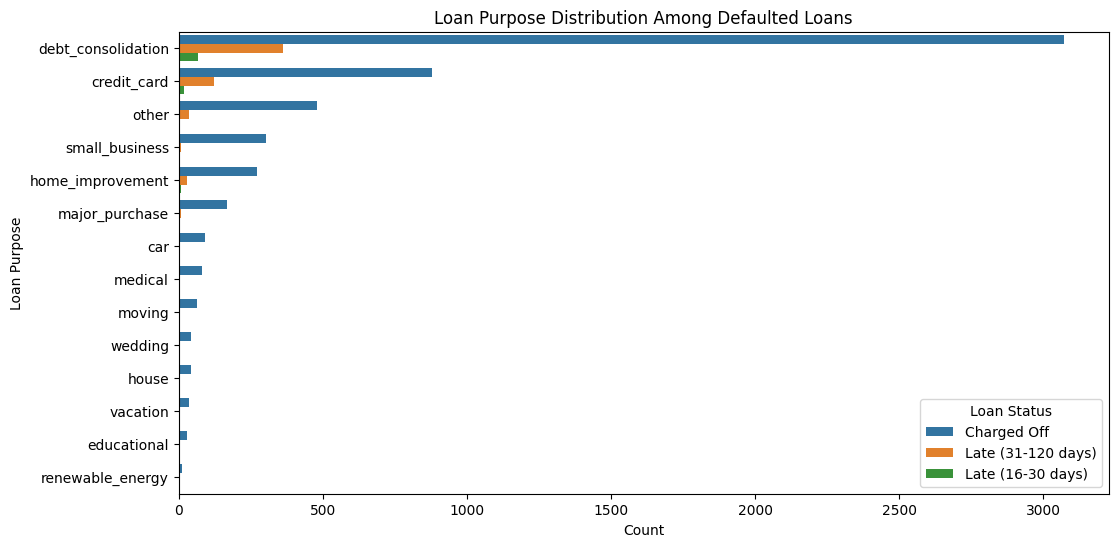

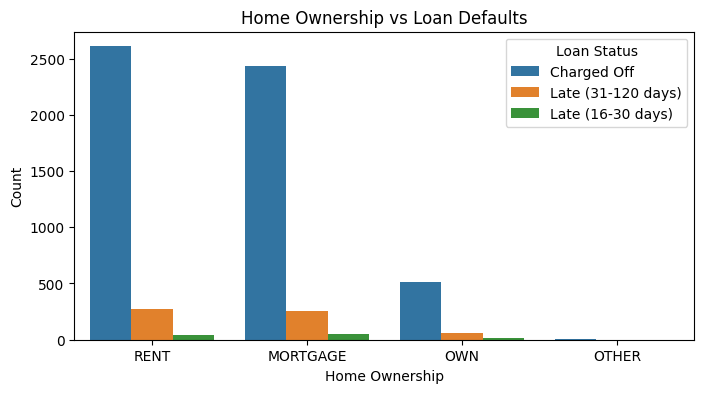

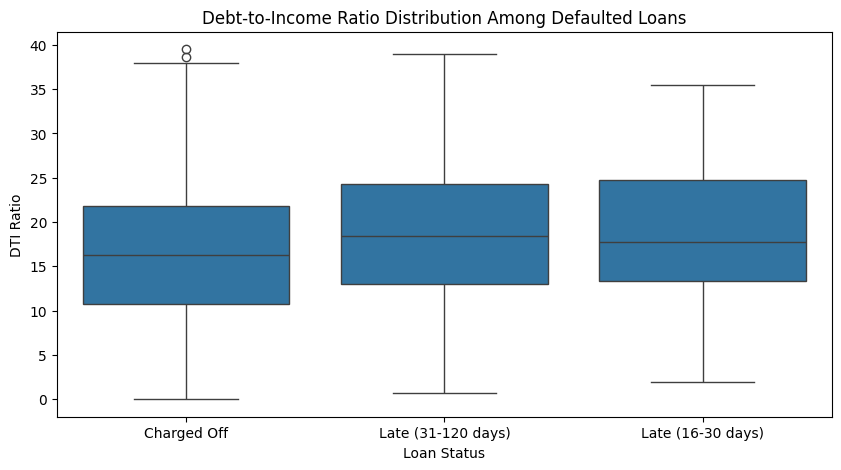

In [28]:
# Create new class for analysing indicators of loss
from classes import LossIndicators
df_loss = LossIndicators(custloan_df)
# Run analysis 
df_loss.run_analysis()